In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import paramiko


In [3]:
path = r"C:\Users\llubowa\Downloads\All sites - Sheet1.csv"
df = pd.read_csv(path)

In [3]:
df.head()

,timestamp,username,status,networkID,siteID,product,siteType,siteName,siteLocation,latitudeLC,...,open,siteCount,originalCommencement,rejectionCount,activationOrderID,deactivationOrderID,masterProtectionDate,installChargeStatus,installTermLength,installTermStart
0,2/13/2015 10:53:24,migrator@csquared.com,Deactivated,UG-KLA-Echotel-Davis_&_Shirtlif,IAL1017,Leased Capacity,Access Site,Davis & Shirtlif,NaN,0.315897,...,,,2/19/2015 0:00:00,NaN,IA-11111111,,,Upfront,12/31/1899 0:00:00,2/12/2015 0:00:00
1,1/22/2015 08:57:04,migrator@csquared.com,Deactivated,UG-KLA-Echotel-UniversityRC,IAL1020,Leased Capacity,Access Site,University-RC,University Research center located in Ntinda,0.345556,...,,,1/29/2015 0:00:00,NaN,IA-B1FBF9B5,,,Upfront,2/4/1900 0:00:00,1/22/2015 0:00:00
2,1/23/2015 09:35:46,migrator@csquared.com,Live,UG-KLA-Echotel-KCBDRSITE,IAL1021,Leased Capacity - 1000 Mbps,Access Site,KCB-DR-SITE,Kololo Near Kolin Construction,0.335556,...,,,1/29/2015 0:00:00,NaN,IA-7417DDC3,,2015-01-23 00:00:00,Upfront,2/4/1900 0:00:00,1/23/2015 0:00:00
3,3/31/2015 13:13:00,migrator@csquared.com,Live,UG-KLA-Echotel-Philips_Pharmaceuticals,IAL1026,Leased Capacity - 100 Mbps,Access Site,Philips Pharmaceuticals,Madhvani Properties\nPlot 96/98\n5th street in...,0.316667,...,,,4/8/2015 0:00:00,NaN,IA-EFDC6F7C,,2015-03-31 00:00:00,Upfront,2/4/1900 0:00:00,3/31/2015 0:00:00
4,2/12/2015 08:24:59,migrator@csquared.com,Deactivated,UG-KLA-Echotel-Climate_change,IAL1023,Leased Capacity,Access Site,Climate change,"Luzira,port bell road",0.298056,...,,,2/18/2015 0:00:00,NaN,IA-2325B951,,,Upfront,2/4/1900 0:00:00,2/11/2015 0:00:00


In [4]:
def wrangle(path):
    df = pd.read_csv(path)
    fields = ['timestamp', 'status', 'networkID', 'product','siteType', 'siteName','latitudeLC', 'longitudeLC','customerShortName','billable']
    df=df[fields]
    df['timestamp']=pd.to_datetime(df['timestamp']).dt.date
    df[['Product','capacity']]= df['product'].str.split("-",1,expand=True)
    df['capacity']=df['capacity'].str.extract('(\d+)').astype(float)
    Search_values=['Port Fiber ','Leased Capacity ']
    replacement_values = ['Port Fiber','Leased Capacity']
    for Search_value,replacement_value  in zip(Search_values,replacement_values):
        df['Product']=df['Product'].str.replace(Search_value,replacement_value)
 
    df.loc[df['Product'] == 'Dark Fiber', 'capacity'] = 1000
    if (df['Product'] == 'Leased Capacity').any():
        df['capacity'].fillna(100,inplace=True)
    
    df['siteName'].fillna(df['customerShortName'],inplace=True)
    df['latitudeLC'].fillna(method='ffill',inplace=True)
    df['longitudeLC'].fillna(method='ffill',inplace=True)
    df.drop(columns=['networkID','product'],inplace=True)
    
        
    return df
    

In [5]:
data = wrangle(path)
data.head()

C:\Users\llubowa\AppData\Local\Temp\ipykernel_20076\230546670.py:6: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['Product','capacity']]= df['product'].str.split("-",1,expand=True)


,timestamp,status,siteType,siteName,latitudeLC,longitudeLC,customerShortName,billable,Product,capacity
0,2015-02-13,Deactivated,Access Site,Davis & Shirtlif,0.315897,32.593444,Echotel,No,Leased Capacity,100.0
1,2015-01-22,Deactivated,Access Site,University-RC,0.345556,32.612500,Echotel,No,Leased Capacity,100.0
2,2015-01-23,Live,Access Site,KCB-DR-SITE,0.335556,32.598611,Echotel,Yes,Leased Capacity,1000.0
3,2015-03-31,Live,Access Site,Philips Pharmaceuticals,0.316667,32.613889,Echotel,Yes,Leased Capacity,100.0
4,2015-02-12,Deactivated,Access Site,Climate change,0.298056,32.650833,Echotel,No,Leased Capacity,100.0


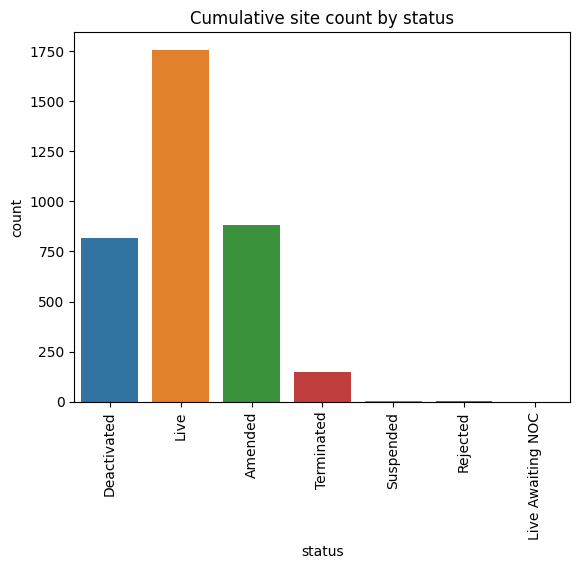

In [24]:
sns.countplot(data=data,x='status').set(title='Cumulative site count by status')
plt.xticks(rotation=90);


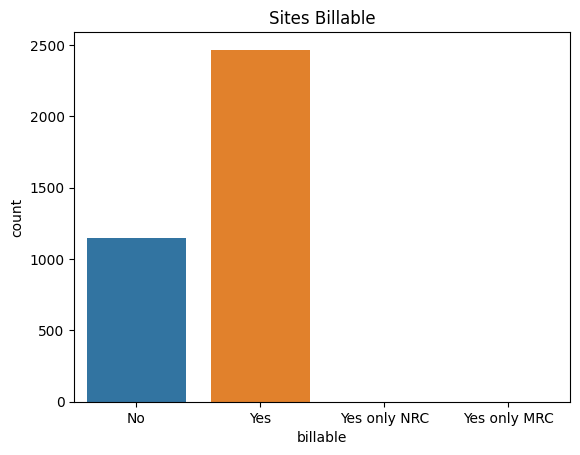

In [11]:
sns.countplot(data=data, x='billable')
plt.title('Sites Billable');

In [20]:
data['longitudeLC'].min()

0.0

In [7]:
px.scatter_geo(data, lat='latitudeLC',lon='longitudeLC',color='Product')

In [39]:
df1 = data.groupby('customerShortName')['status'].value_counts().rename('Count').reset_index()
df1['customerShortName'] = df1['customerShortName'].astype('category')
df1['status'] = df1['status'].astype('category')
df1.head()

,customerShortName,status,Count
0,Africell,Terminated,149
1,Africell,Deactivated,1
2,Airtel,Live,202
3,Airtel,Deactivated,1
4,BCS,Live,14


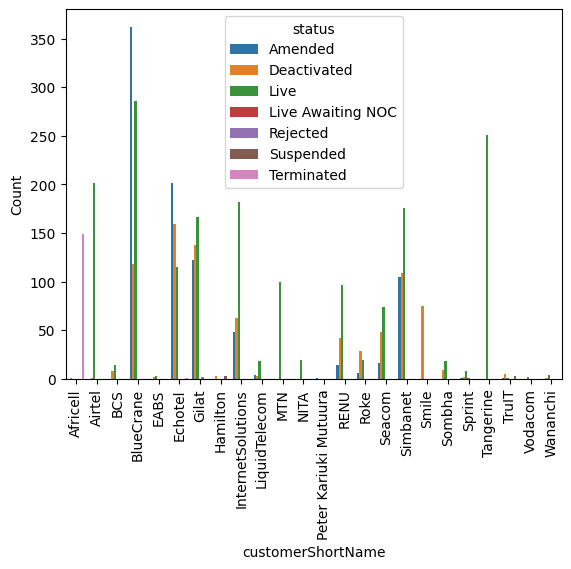

In [48]:

sns.barplot(data=df1, x='customerShortName', y='Count', hue='status', estimator='sum')
plt.xticks(rotation=90);